In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import find_peaks
import sys
from scipy.fft import rfft, rfftfreq

In [3]:
video = cv2.VideoCapture('/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject13/vid.avi')

fps = video.get(cv2.CAP_PROP_FPS)

print('FPS:', fps)

video.release()

FPS: 29.7903


In [4]:
npz_file_path = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz'

data = np.load(npz_file_path)
print(data['video'].shape)
print(data['wave'].shape)
print(data['hr'].shape)

(1547, 64, 64, 3)
(1547,)
(1547,)


rPPG based Average Heart Rate (BPM):  107.19847196870926
Actual Average Heart Rate:  106.70456819650937


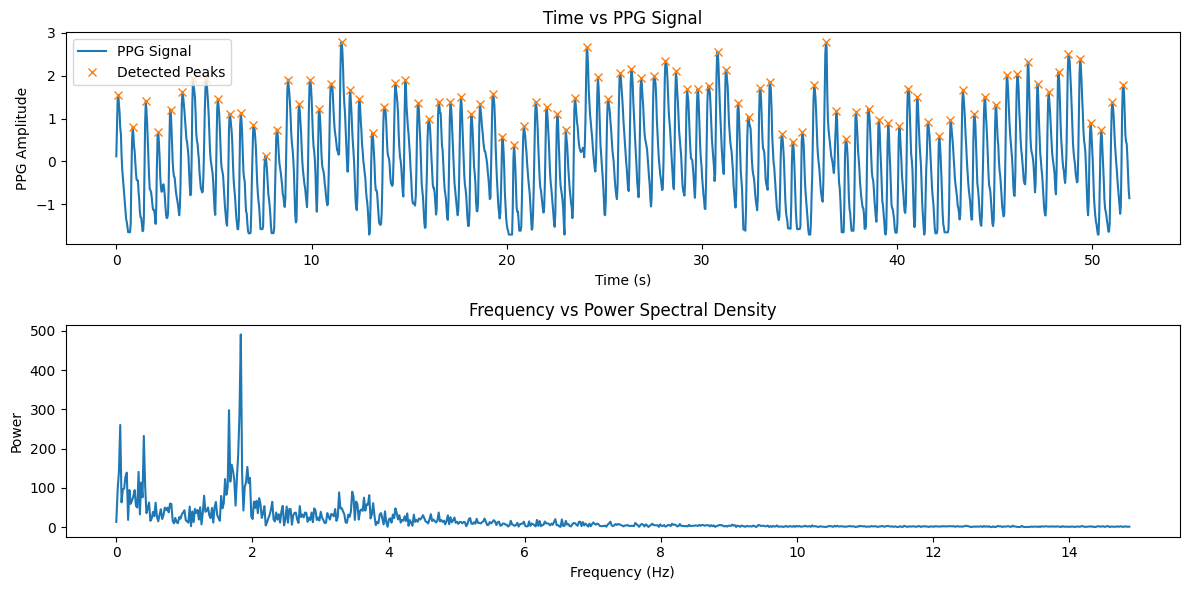

In [40]:
PPG_Signal = data['wave']
time = np.arange(PPG_Signal.size) / fps  # 30FPS로 촬영된 데이터, 시간 배열 생성

# FFT를 사용해 신호의 주파수 도메인 변환
psd = np.abs(rfft(PPG_Signal))
freqs = rfftfreq(PPG_Signal.size, 1 / fps)  # 샘플링 레이트는 초당 30프레임

# 신호에서 피크 찾기
peak_indices, _ = find_peaks(PPG_Signal, distance=10)  # 적절한 거리 설정
IBI = np.diff(peak_indices) / fps  # IBI 계산, 초 단위로 변환

# 모든 IBI 값의 평균을 계산
average_IBI = np.mean(IBI)
bpm_avg = 60 / average_IBI  # 분당 박동수 계산

print("rPPG based Average Heart Rate (BPM): ", bpm_avg)
print("Actual Average Heart Rate: ", np.mean(data['hr']))

# 플로팅
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, PPG_Signal, label='PPG Signal')
plt.plot(time[peak_indices], PPG_Signal[peak_indices], "x", label='Detected Peaks')
plt.title('Time vs PPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('PPG Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freqs, psd)
plt.title('Frequency vs Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

In [86]:
def calculate_hr(npz_data, fps=fps, window_size=150, step_size=30):
    """심박수 계산 및 시간 배열 반환"""
    PPG_Signal = npz_data['wave']
    hr_real = npz_data['hr']  # 실제 심박수 데이터
    bpm_per_frame = []
    times = []

    for start in range(0, len(PPG_Signal) - window_size, step_size):
        end = start + window_size
        segment = PPG_Signal[start:end]
        peaks, _ = find_peaks(segment, distance=10)

        if len(peaks) > 1:
            ibi = np.diff(peaks) / fps
            bpm = 60 / np.mean(ibi) if len(ibi) > 0 else np.nan
        else:
            bpm = np.nan

        bpm_per_frame.append(bpm)
        times.append((start + end) / 2 / fps)

    return times, bpm_per_frame, hr_real

def plot_hr(times, bpm_per_frame, hr_real):
    """심박수 데이터 플롯 및 평균 값 출력"""
    # hr_real에서 10 이하인 값을 NaN으로 설정
    hr_real_filtered = np.array(hr_real)
    hr_real_filtered[hr_real_filtered <= 10] = np.nan

    plt.figure(figsize=(20, 5))
    plt.plot(times, bpm_per_frame, label='Estimated BPM', color='blue', alpha=0.6)
    plt.plot(np.arange(len(hr_real_filtered)) / fps, hr_real_filtered, label='Actual HR', color='red', alpha=0.6)
    plt.title('Estimated vs Actual Heart Rate Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Heart Rate (BPM)')
    plt.legend()
    plt.show()

    # 계산된 BPM과 실제 HR의 평균 계산
    # NaN 값을 무시하고 평균 계산
    mean_estimated_bpm = np.nanmean(bpm_per_frame)
    mean_actual_hr = np.nanmean(hr_real_filtered)

    # 결과 출력
    print(f"Average Estimated BPM: {mean_estimated_bpm:.2f}")
    print(f"Average Actual HR: {mean_actual_hr:.2f}")
    print("---------------------------------------------------------------------------")

def process_npz_files(directory):
    """디렉토리 내의 모든 NPZ 파일 처리"""
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.npz'):
            file_path = os.path.join(directory, file_name)
            print(f"Processing {file_path}...")
            npz_data = np.load(file_path)
            times, bpm_per_frame, hr_real = calculate_hr(npz_data)
            plot_hr(times, bpm_per_frame, hr_real)

Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz...


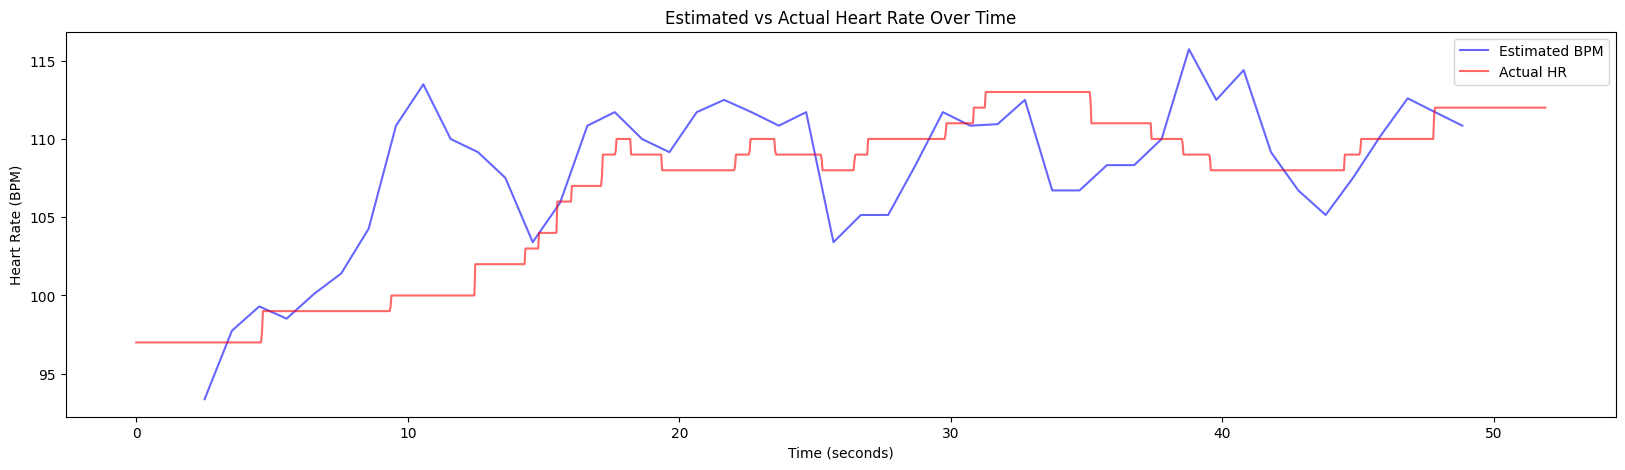

Average Estimated BPM: 108.08
Average Actual HR: 106.70
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject10.npz...


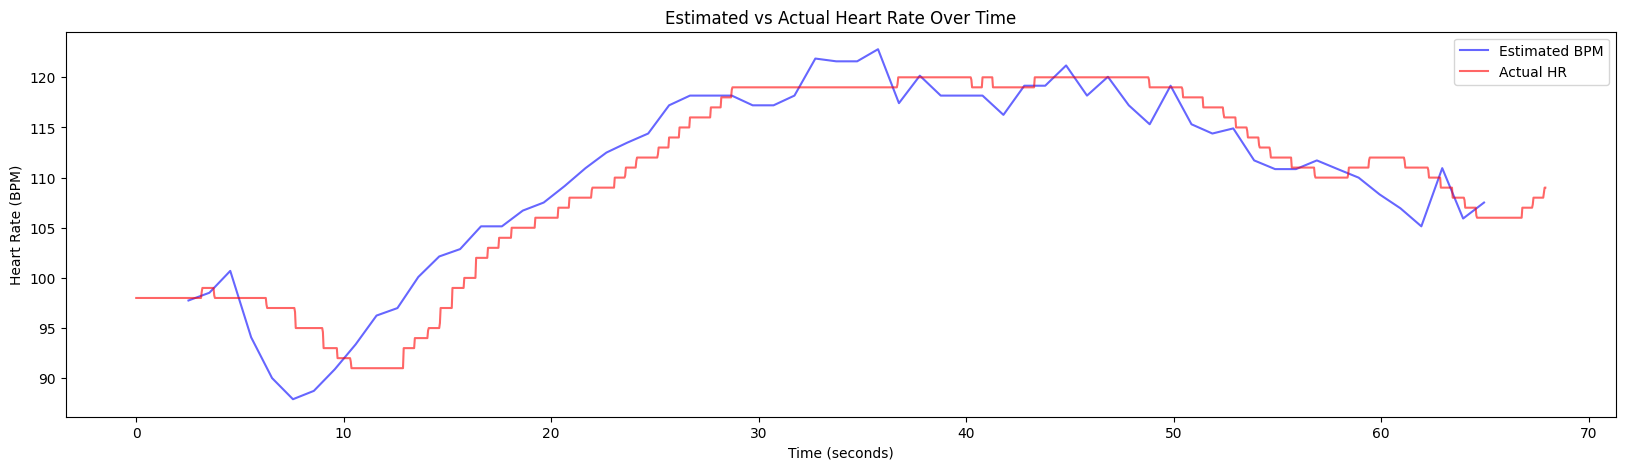

Average Estimated BPM: 110.33
Average Actual HR: 109.81
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject11.npz...


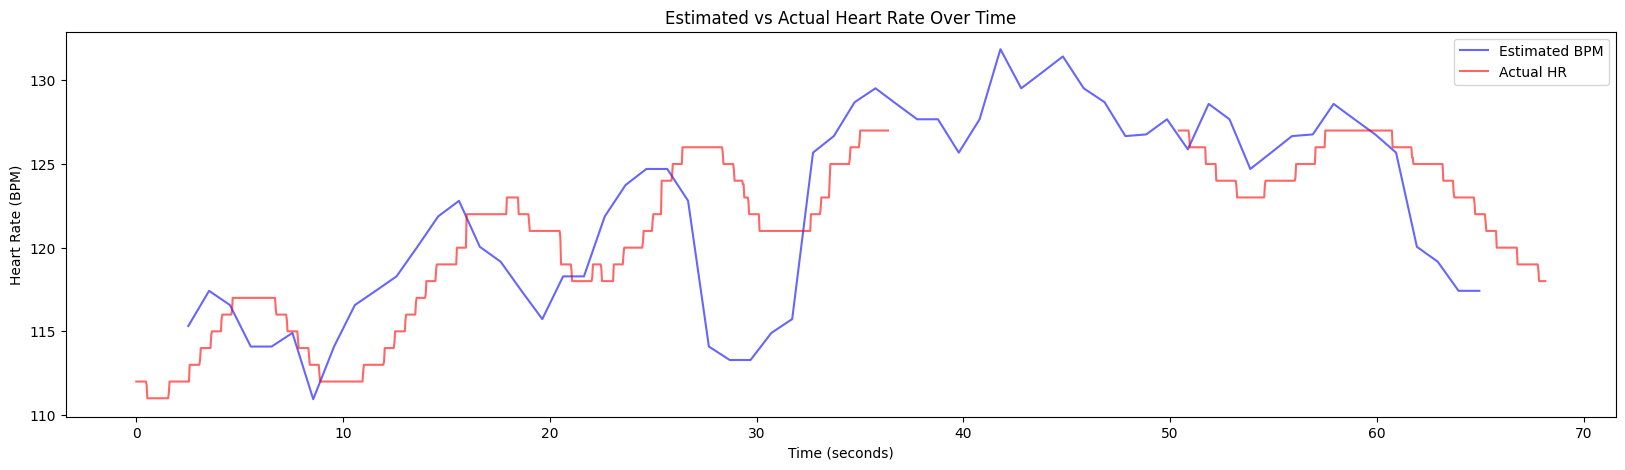

Average Estimated BPM: 122.41
Average Actual HR: 120.68
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject12.npz...


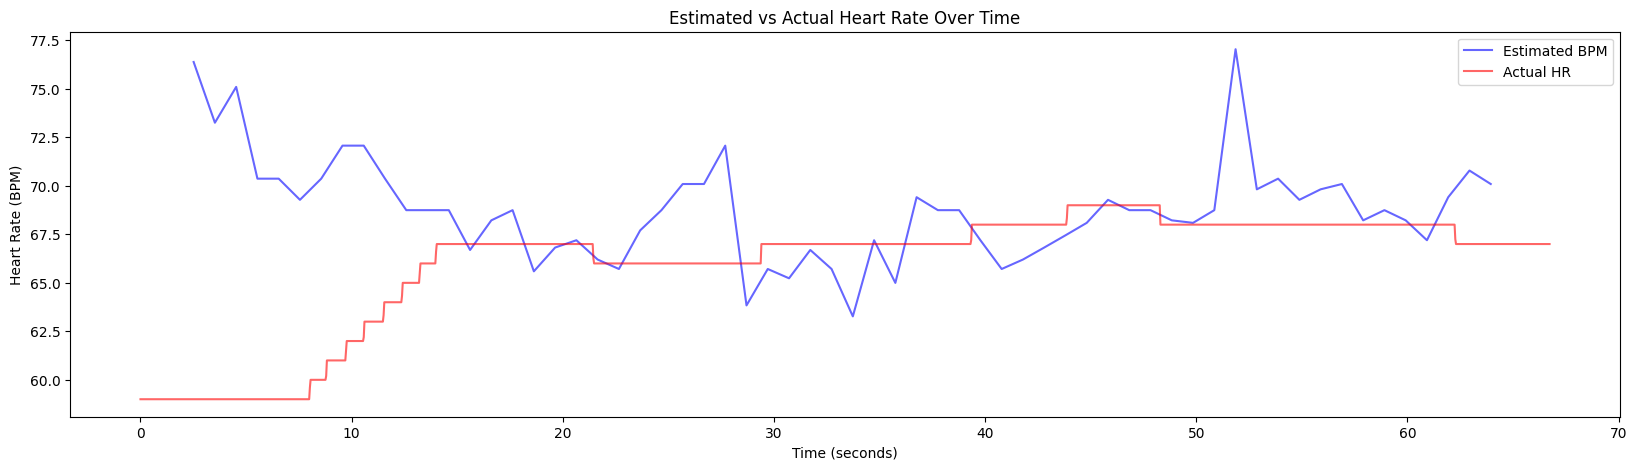

Average Estimated BPM: 68.74
Average Actual HR: 65.97
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject13.npz...


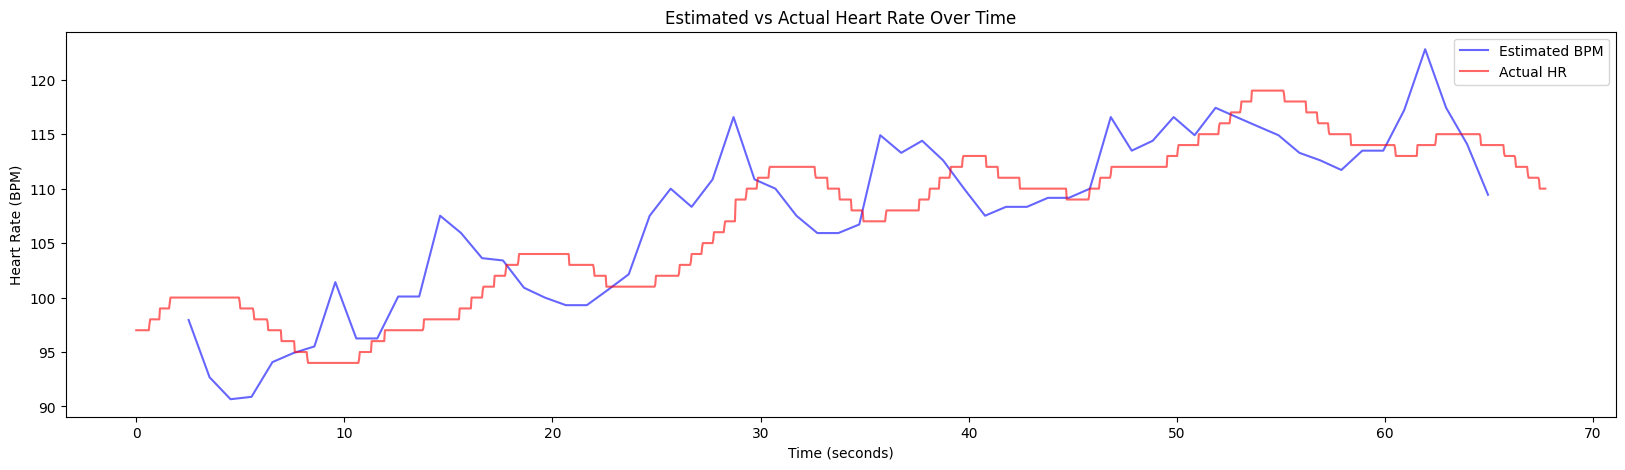

Average Estimated BPM: 107.58
Average Actual HR: 107.10
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject14.npz...


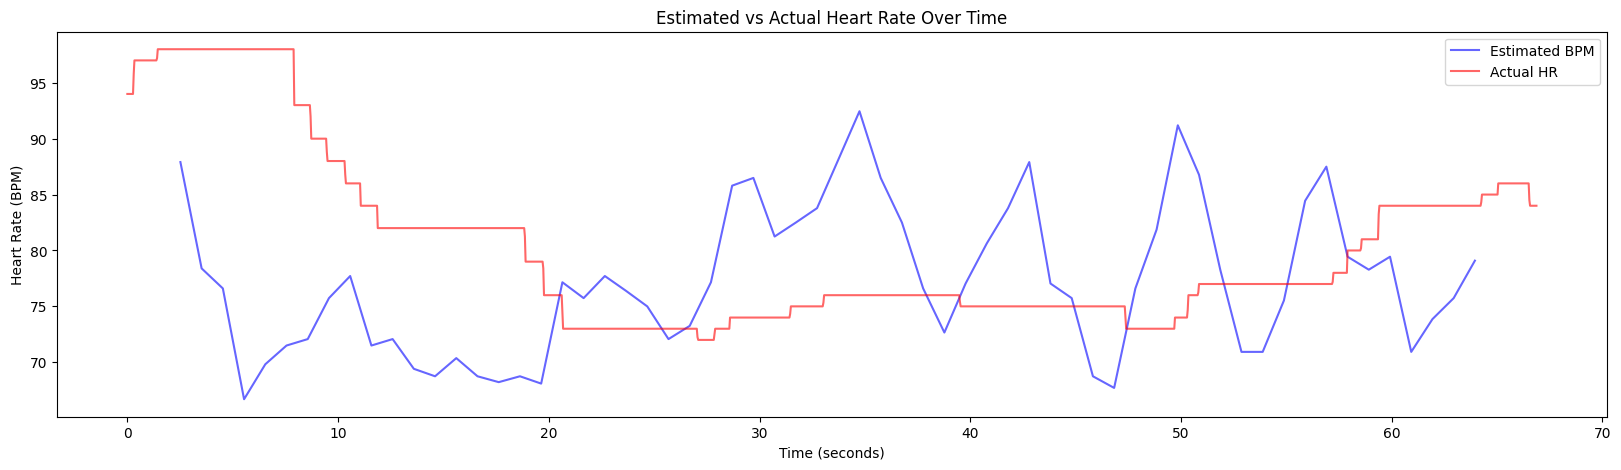

Average Estimated BPM: 77.18
Average Actual HR: 80.41
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject15.npz...


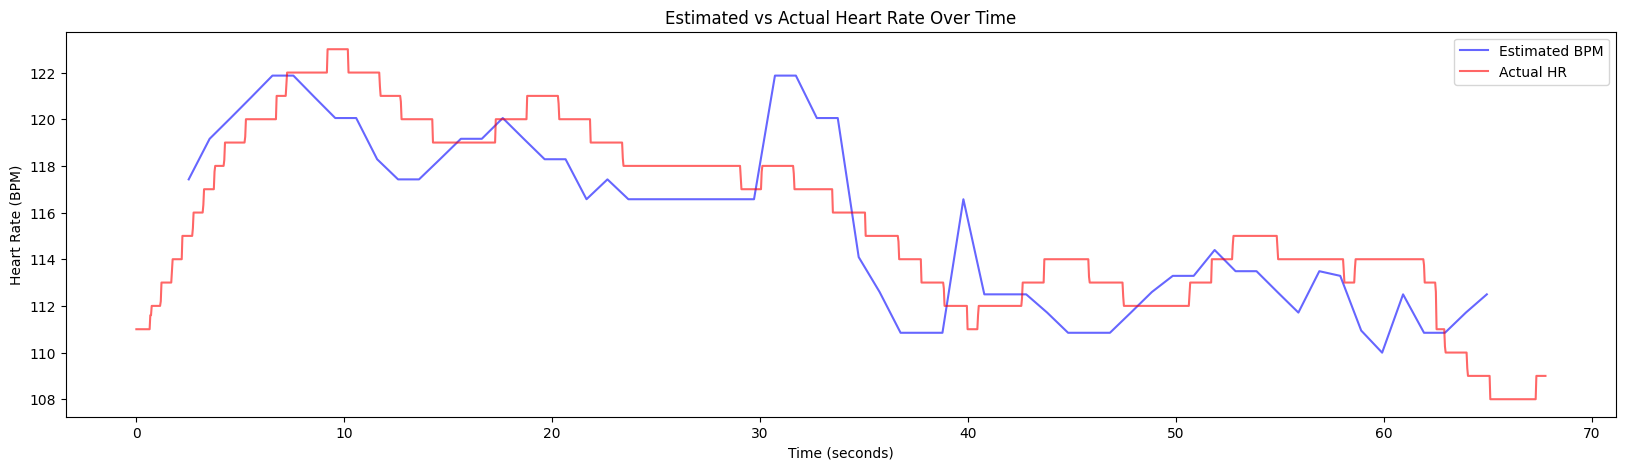

Average Estimated BPM: 115.59
Average Actual HR: 115.79
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject16.npz...


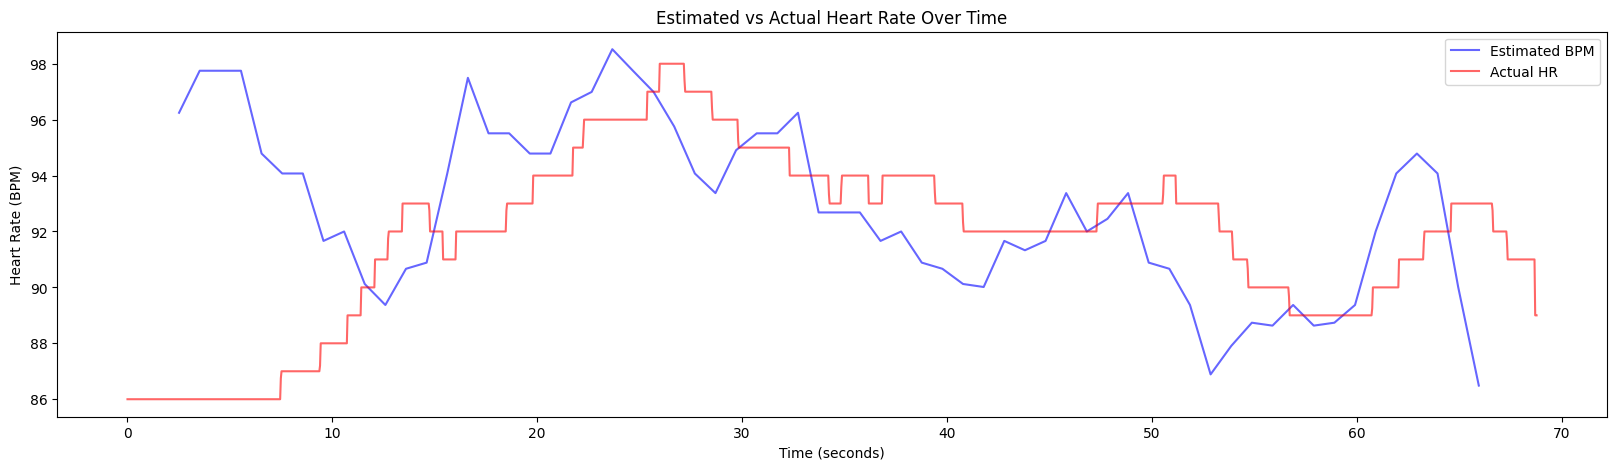

Average Estimated BPM: 92.83
Average Actual HR: 91.80
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject17.npz...


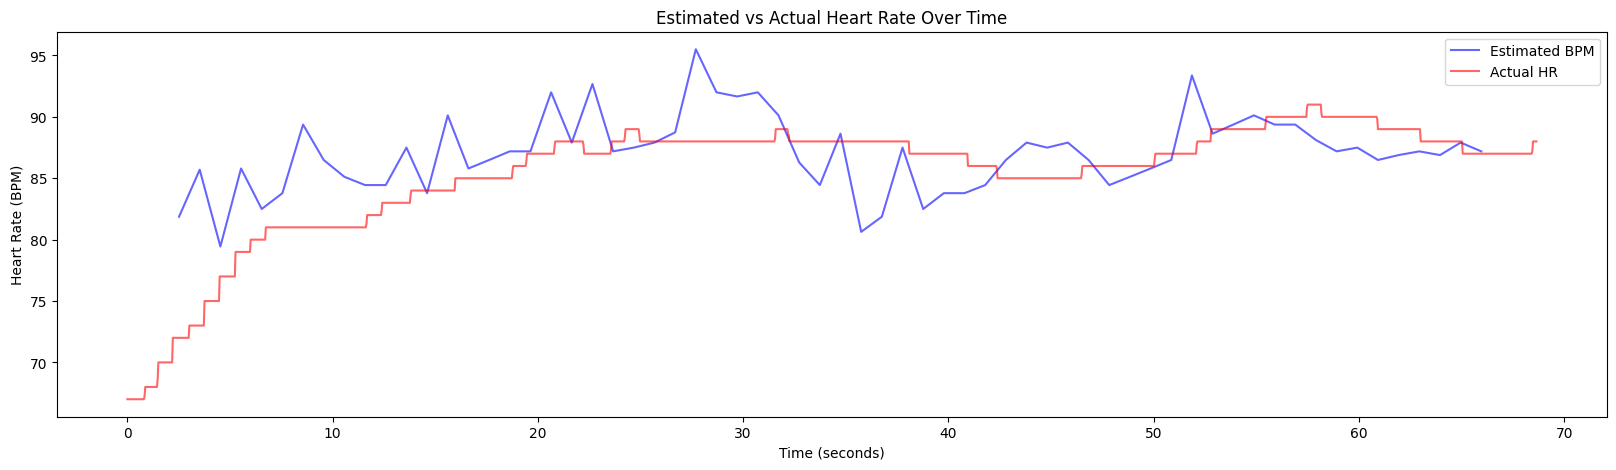

Average Estimated BPM: 87.03
Average Actual HR: 85.40
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject18.npz...


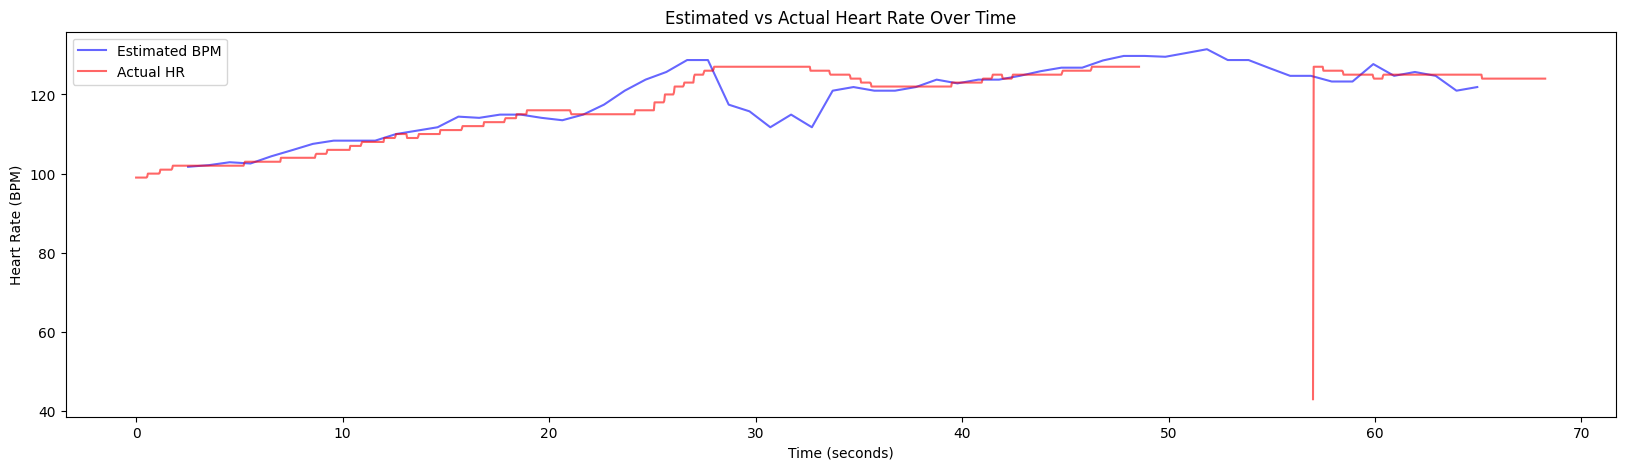

Average Estimated BPM: 119.24
Average Actual HR: 117.91
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject20.npz...


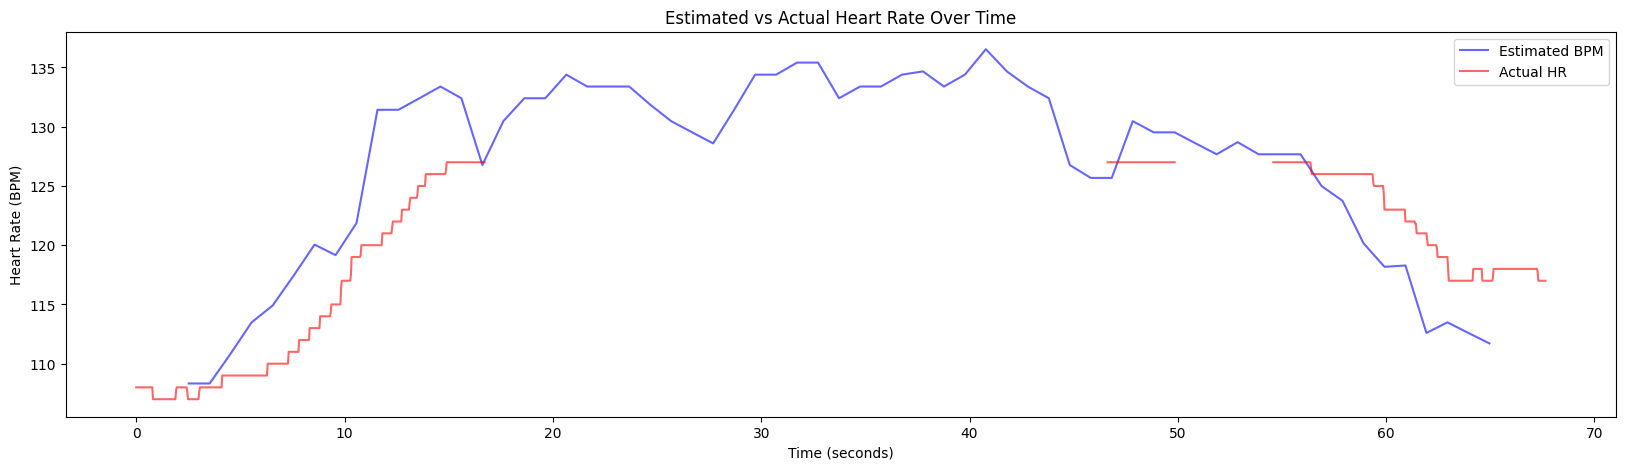

Average Estimated BPM: 127.11
Average Actual HR: 119.05
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject22.npz...


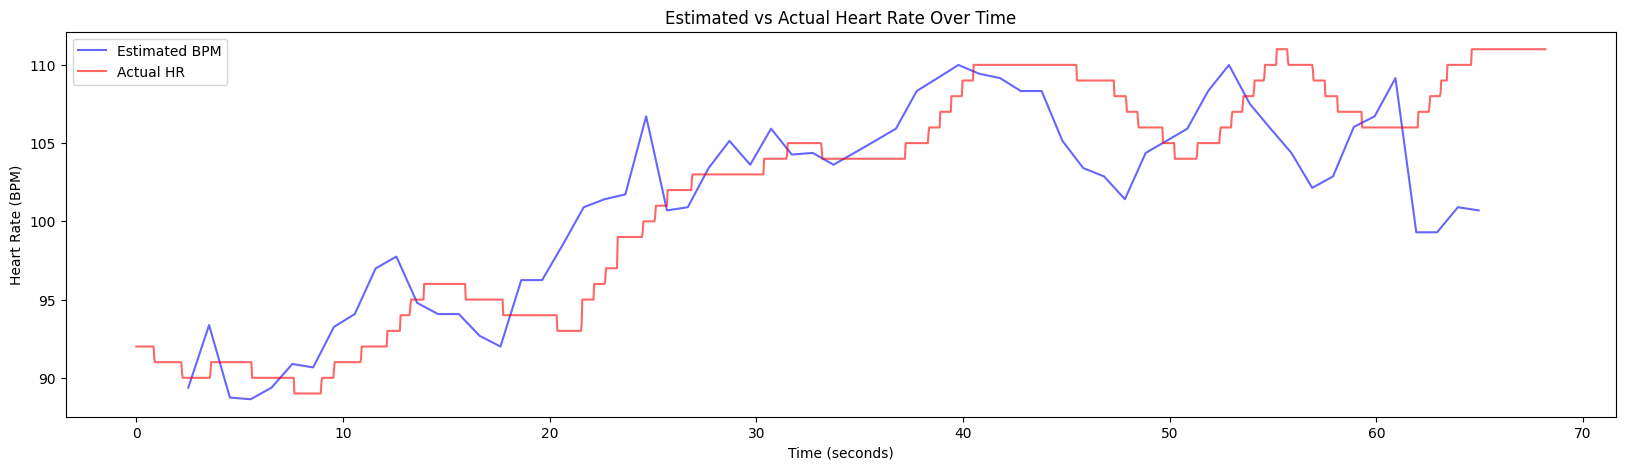

Average Estimated BPM: 101.34
Average Actual HR: 101.79
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject23.npz...


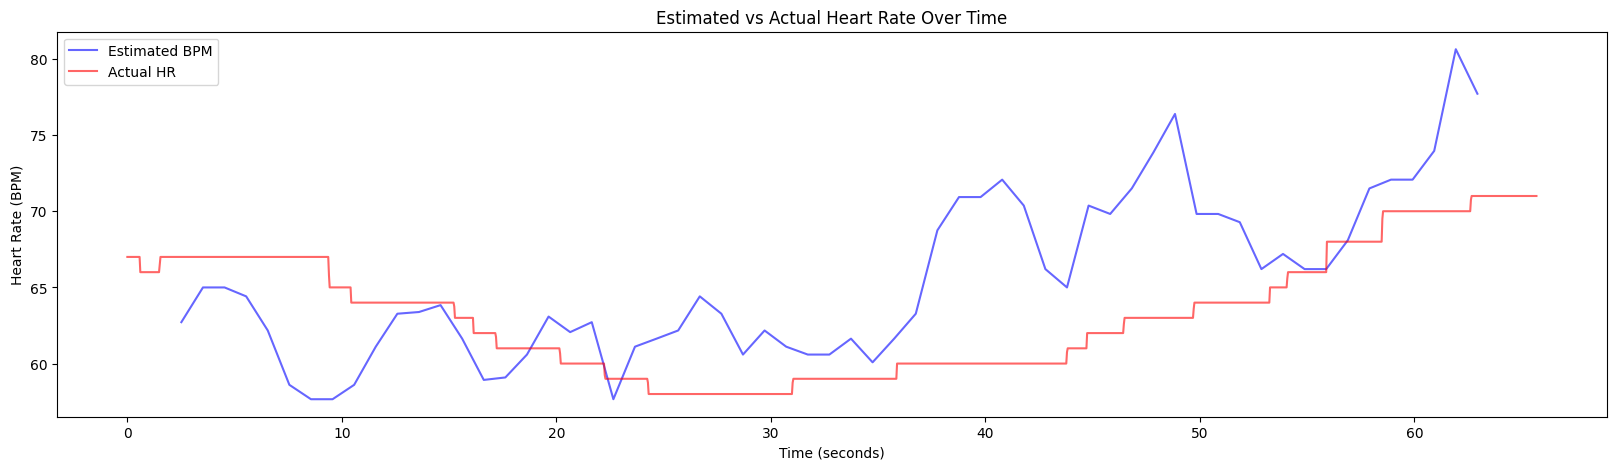

Average Estimated BPM: 65.42
Average Actual HR: 63.29
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject24.npz...


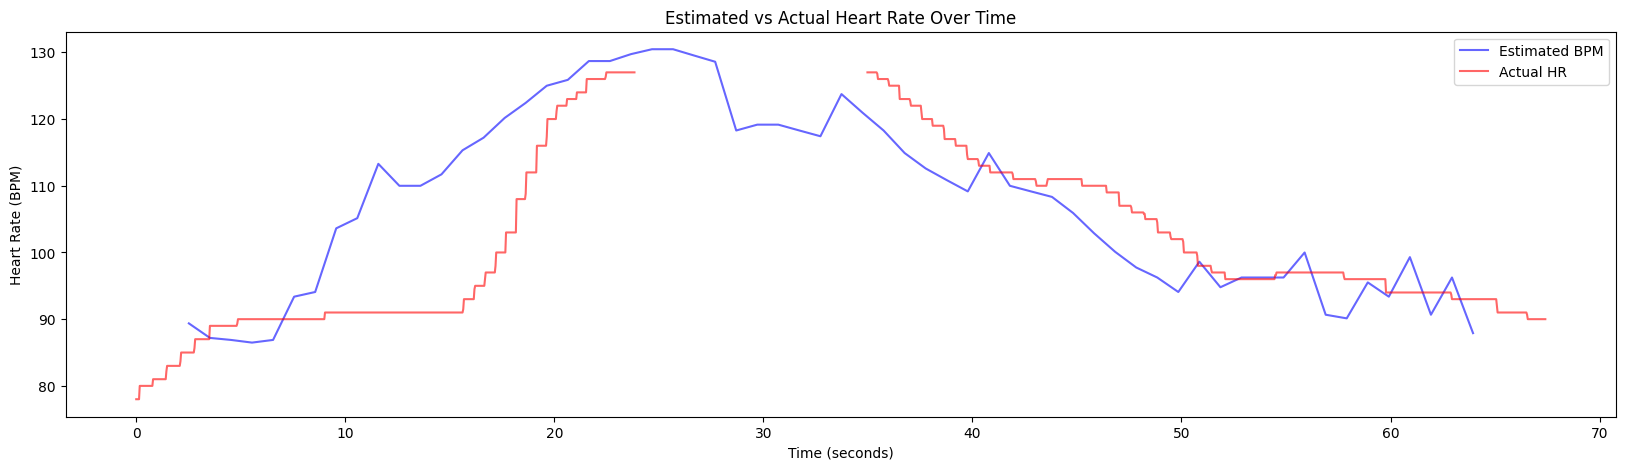

Average Estimated BPM: 107.71
Average Actual HR: 100.90
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject25.npz...


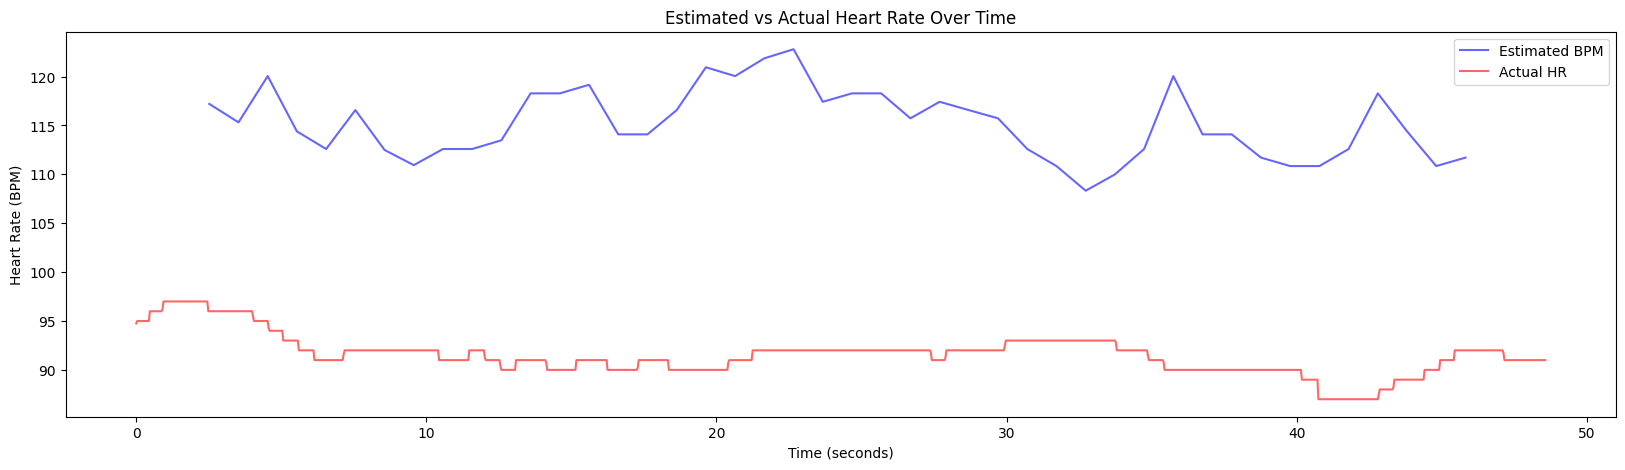

Average Estimated BPM: 115.17
Average Actual HR: 91.53
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject26.npz...


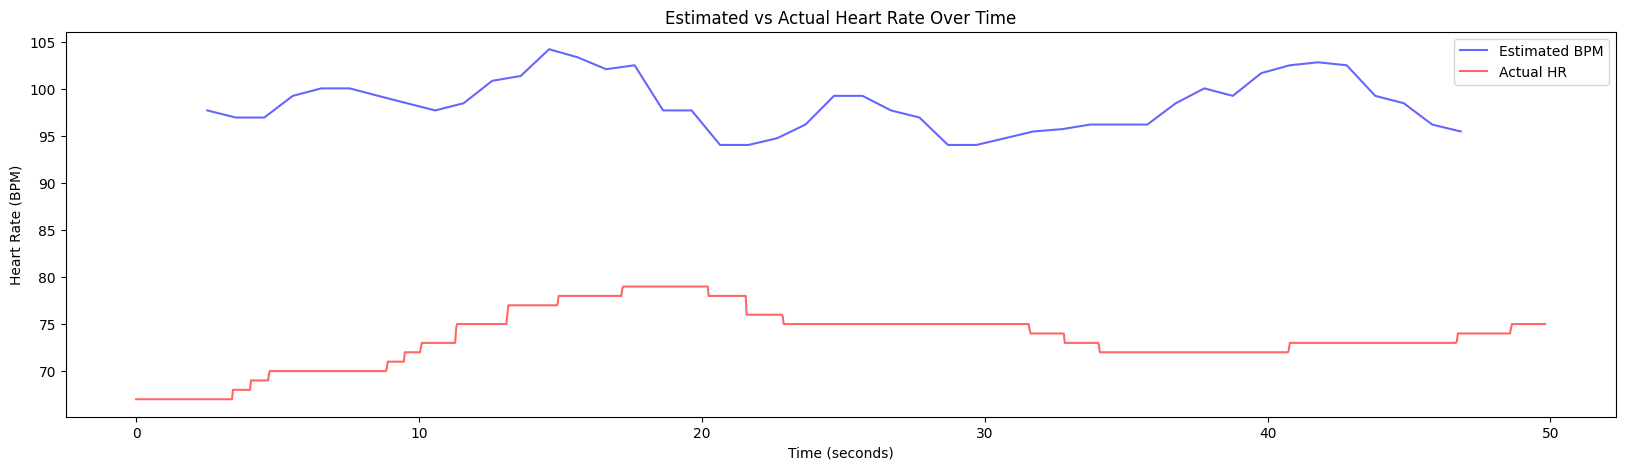

Average Estimated BPM: 98.40
Average Actual HR: 73.53
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject27.npz...


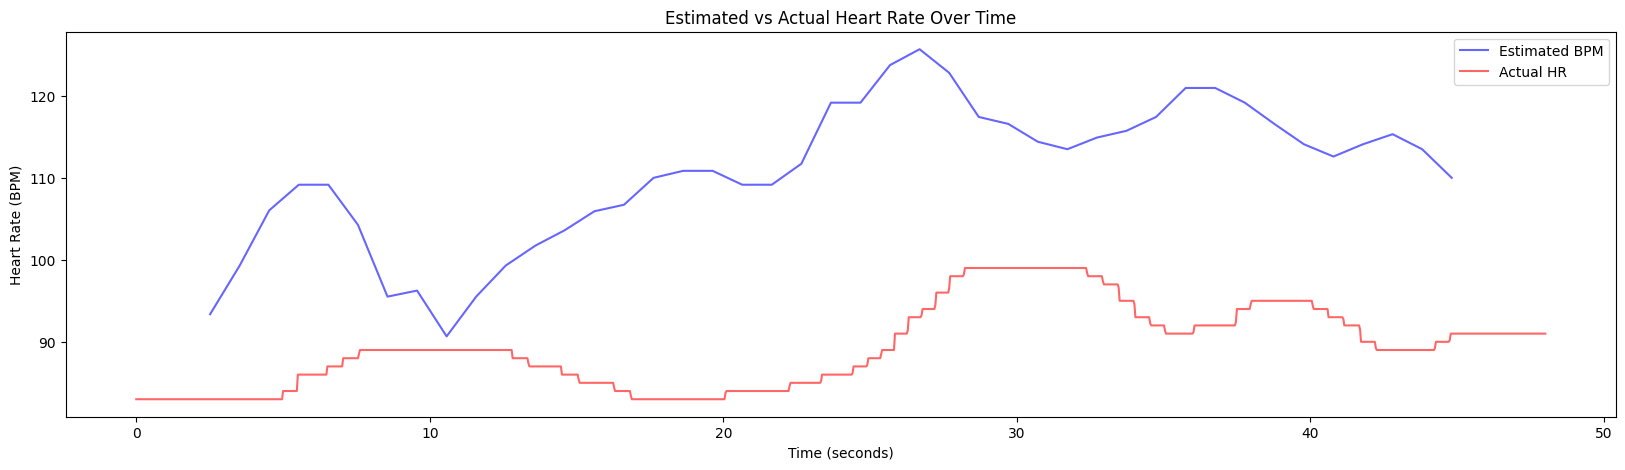

Average Estimated BPM: 110.60
Average Actual HR: 89.37
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject3.npz...


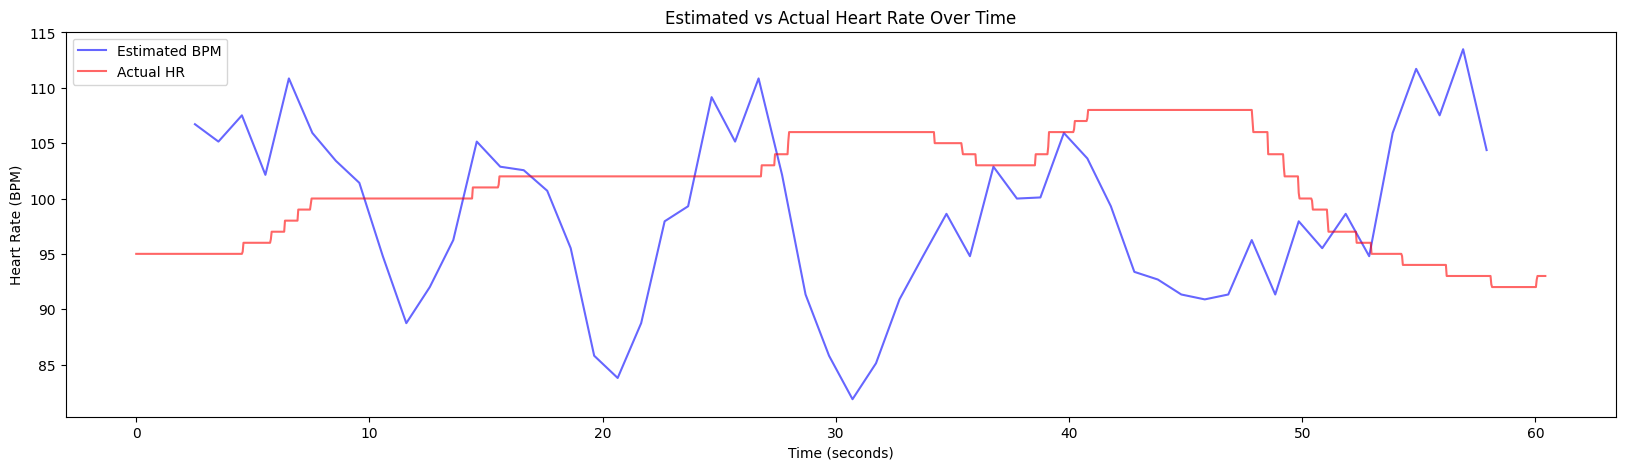

Average Estimated BPM: 98.51
Average Actual HR: 101.17
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject30.npz...


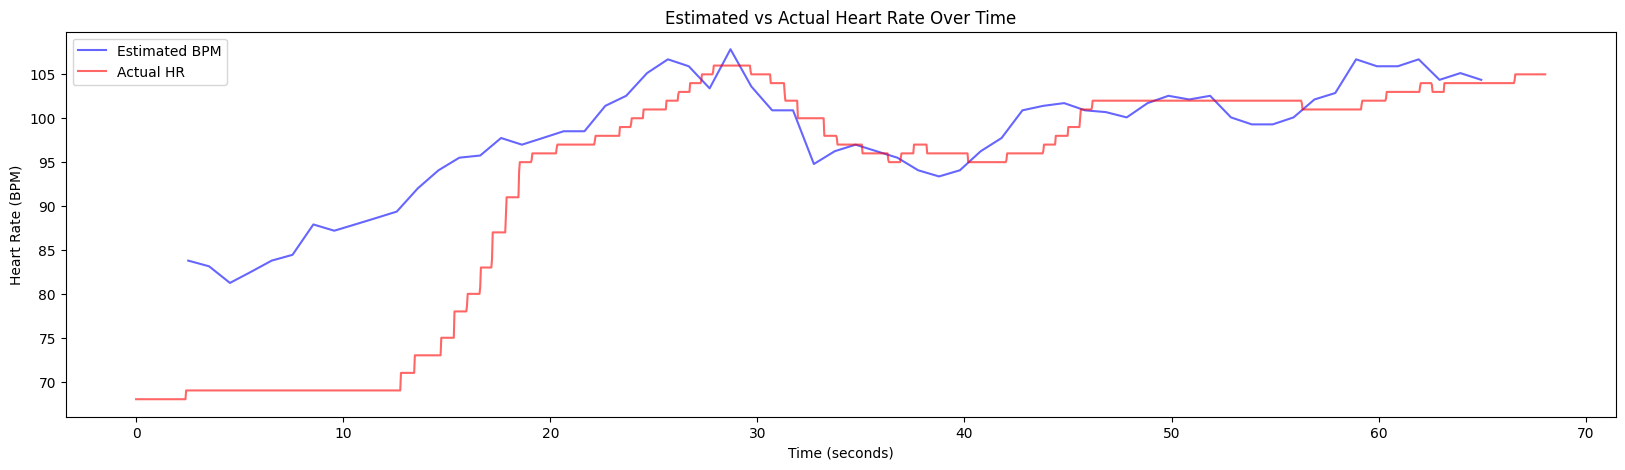

Average Estimated BPM: 97.75
Average Actual HR: 92.71
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject31.npz...


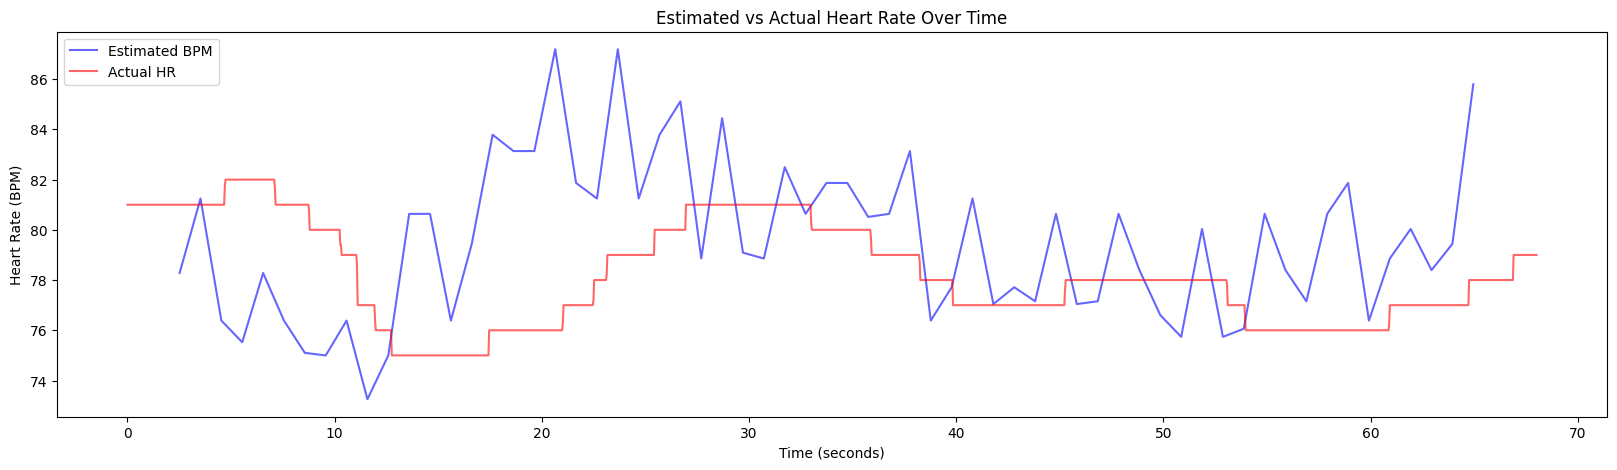

Average Estimated BPM: 79.54
Average Actual HR: 78.24
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject32.npz...


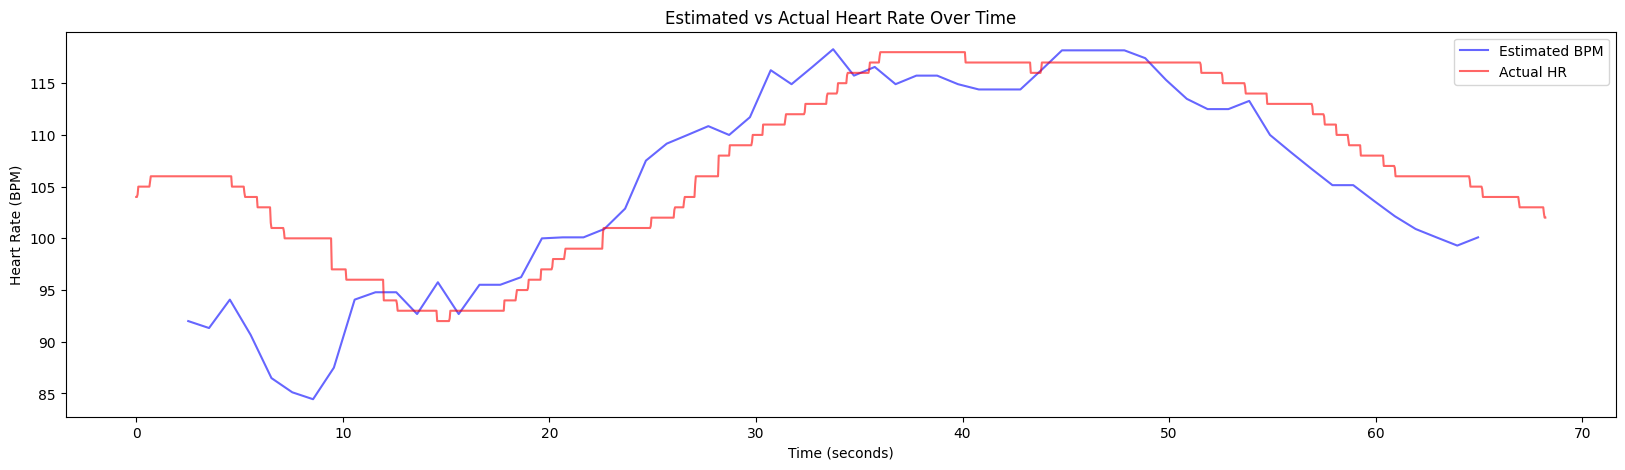

Average Estimated BPM: 105.47
Average Actual HR: 107.33
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject33.npz...


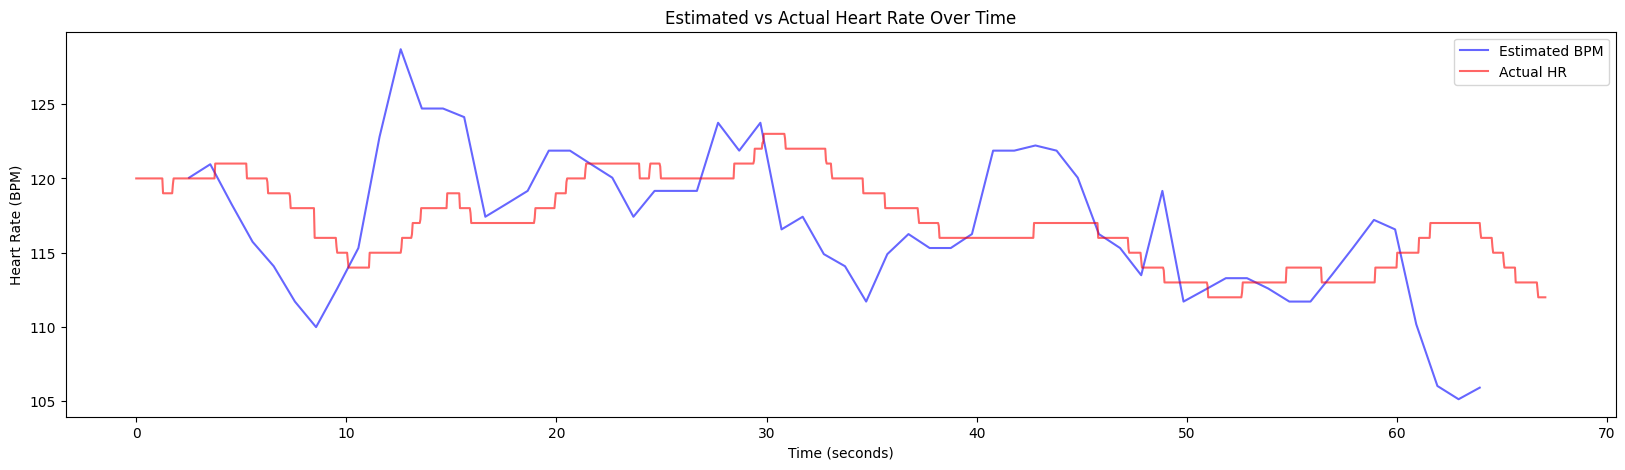

Average Estimated BPM: 116.92
Average Actual HR: 117.18
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject34.npz...


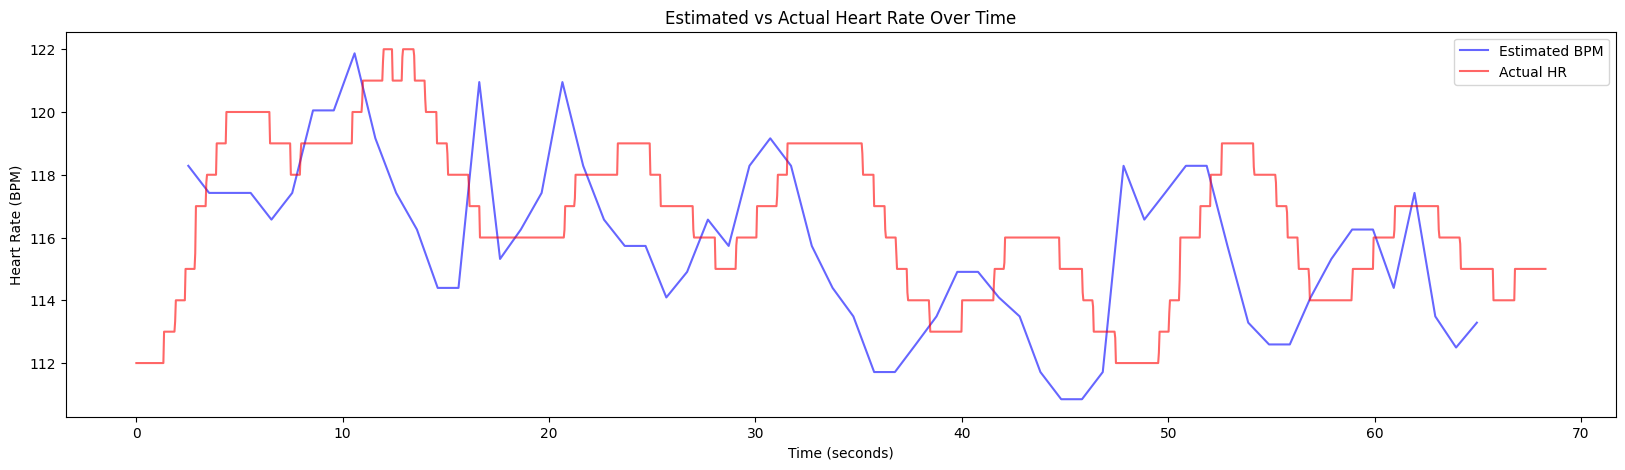

Average Estimated BPM: 115.78
Average Actual HR: 116.55
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject35.npz...


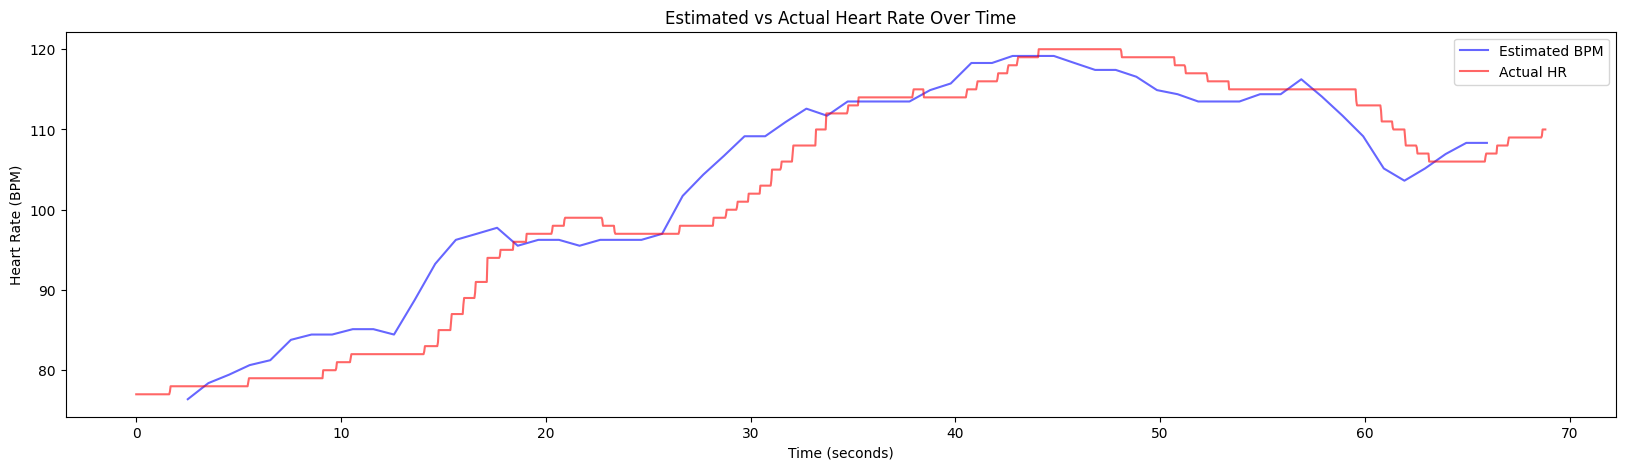

Average Estimated BPM: 103.87
Average Actual HR: 102.36
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject36.npz...


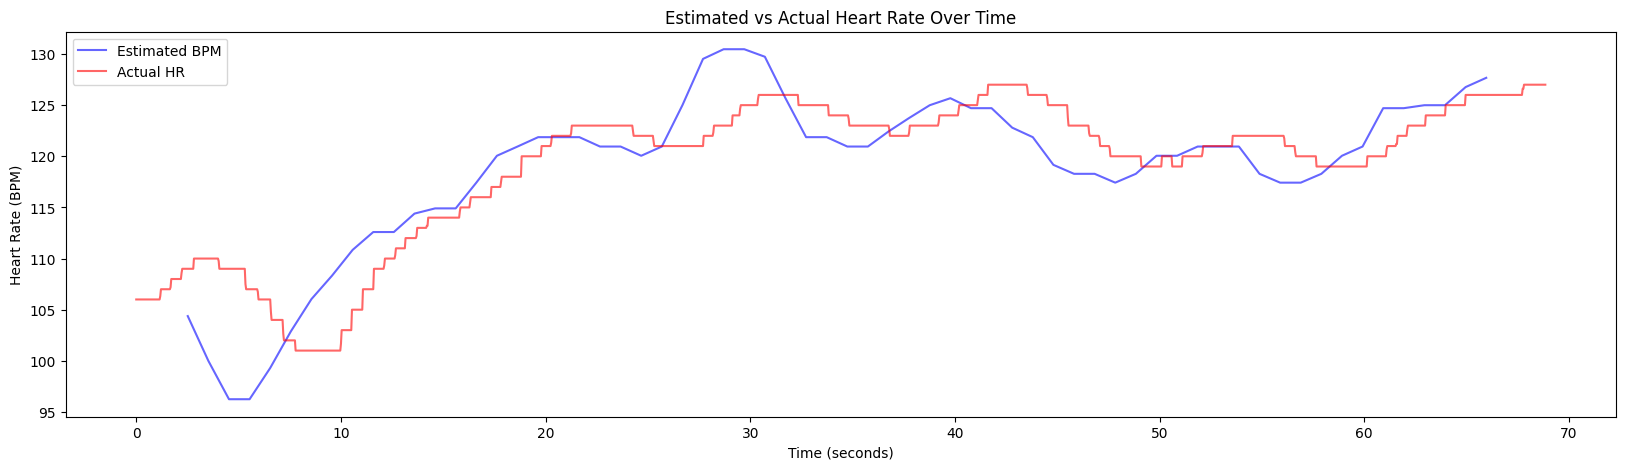

Average Estimated BPM: 118.89
Average Actual HR: 119.02
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject37.npz...


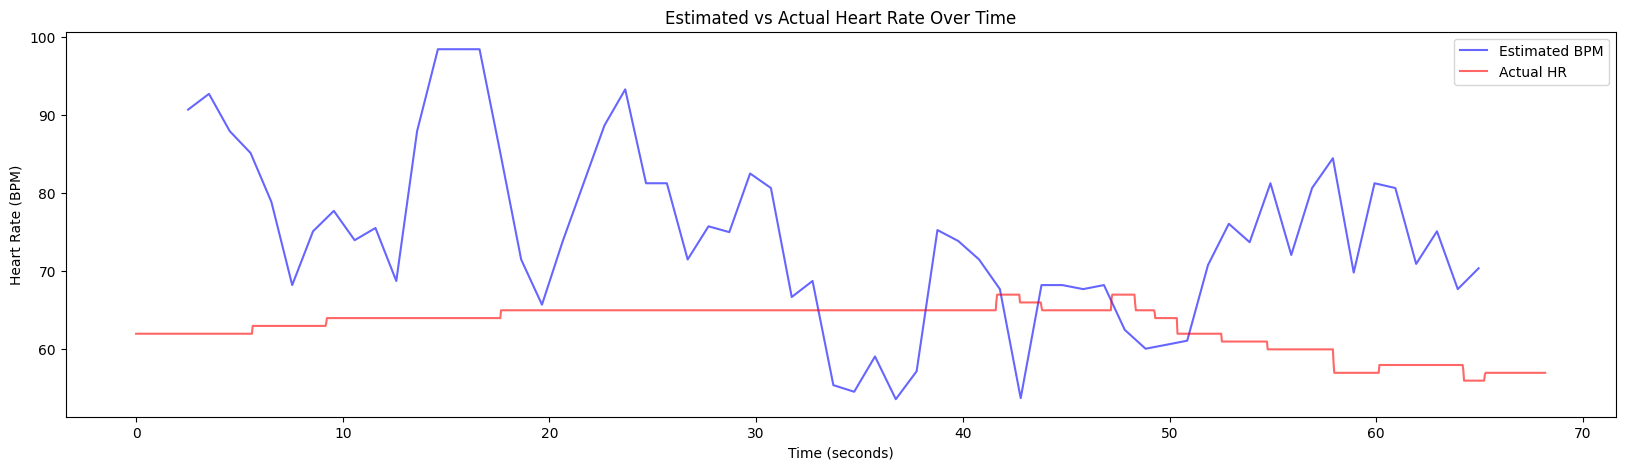

Average Estimated BPM: 74.50
Average Actual HR: 62.97
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject38.npz...


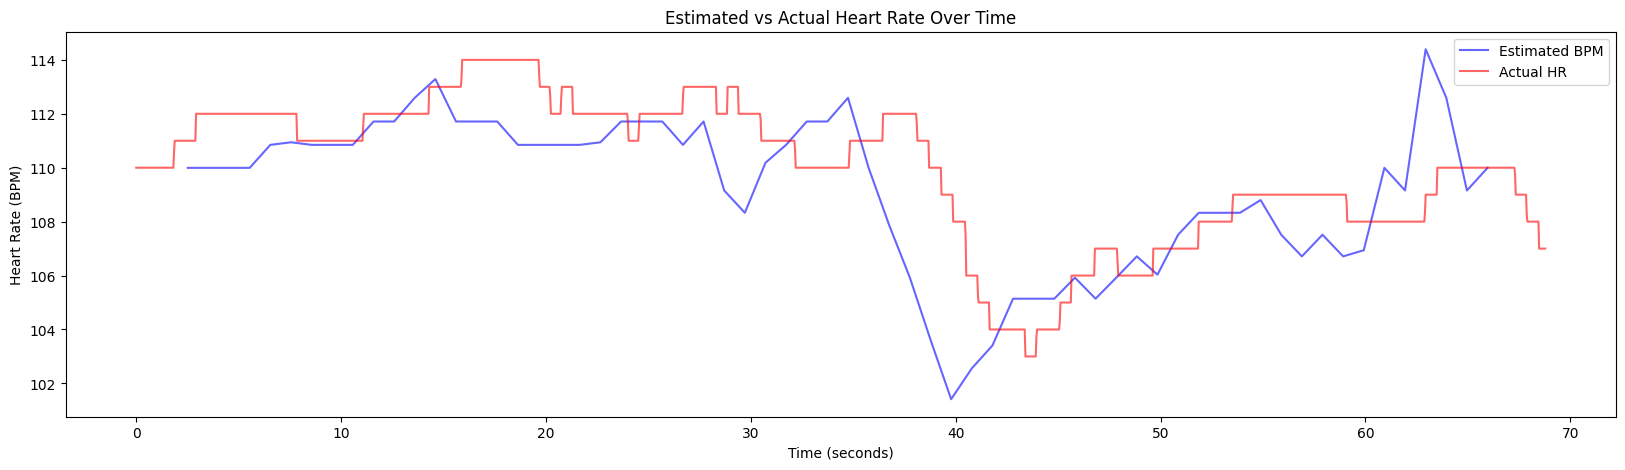

Average Estimated BPM: 109.18
Average Actual HR: 110.00
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject39.npz...


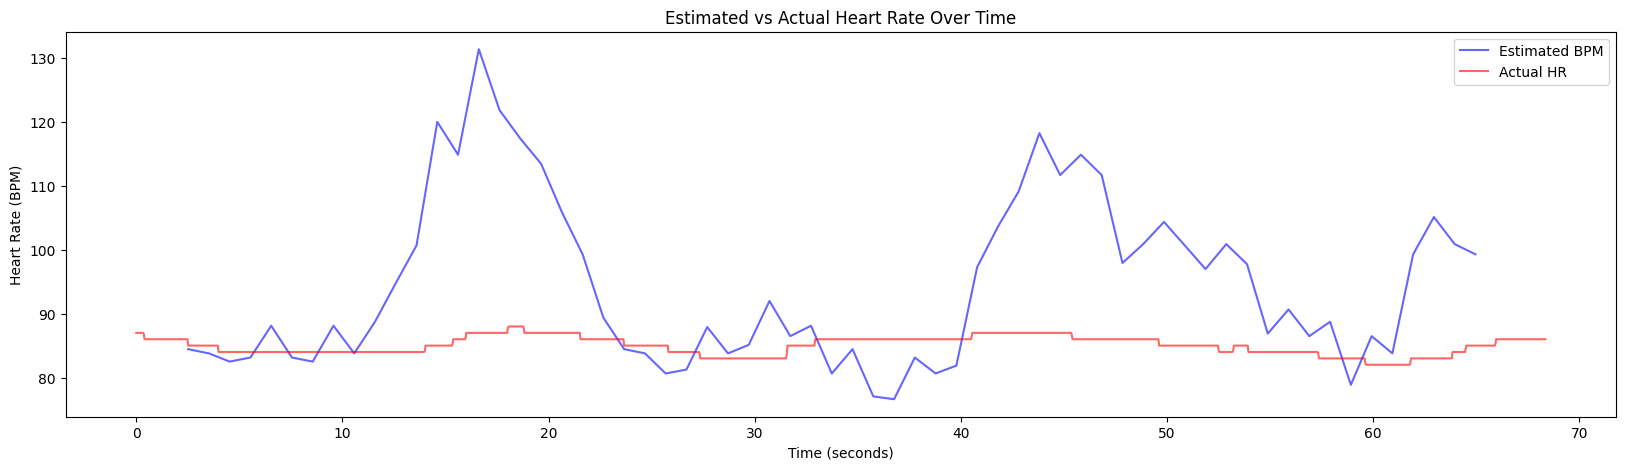

Average Estimated BPM: 94.42
Average Actual HR: 85.02
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject4.npz...


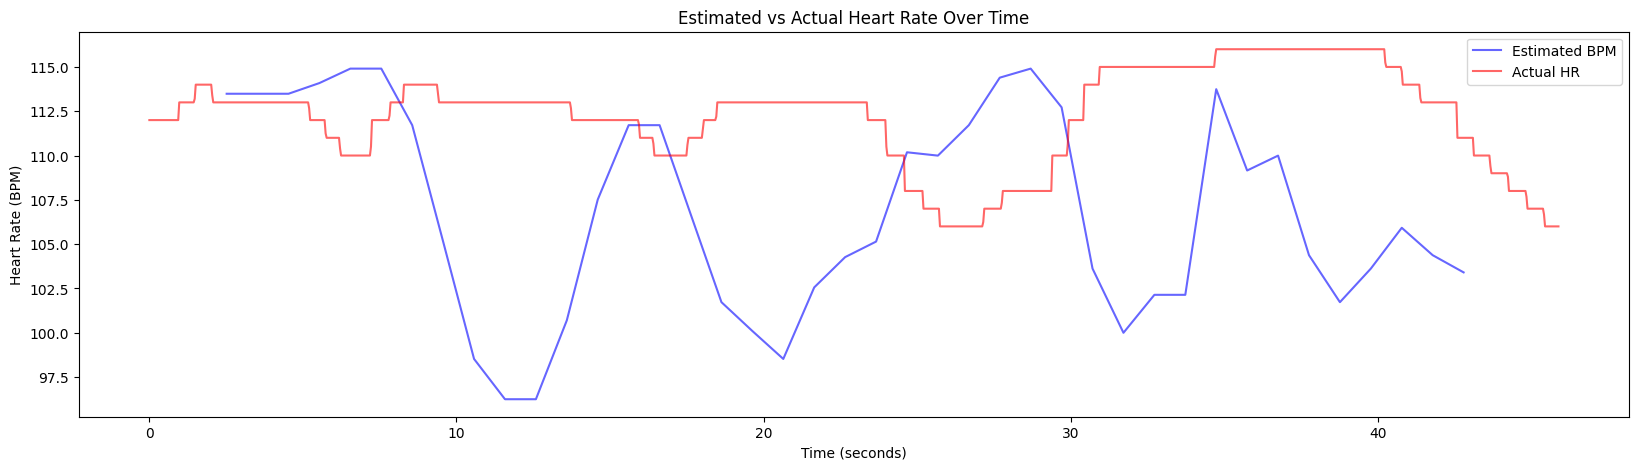

Average Estimated BPM: 106.85
Average Actual HR: 112.27
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject40.npz...


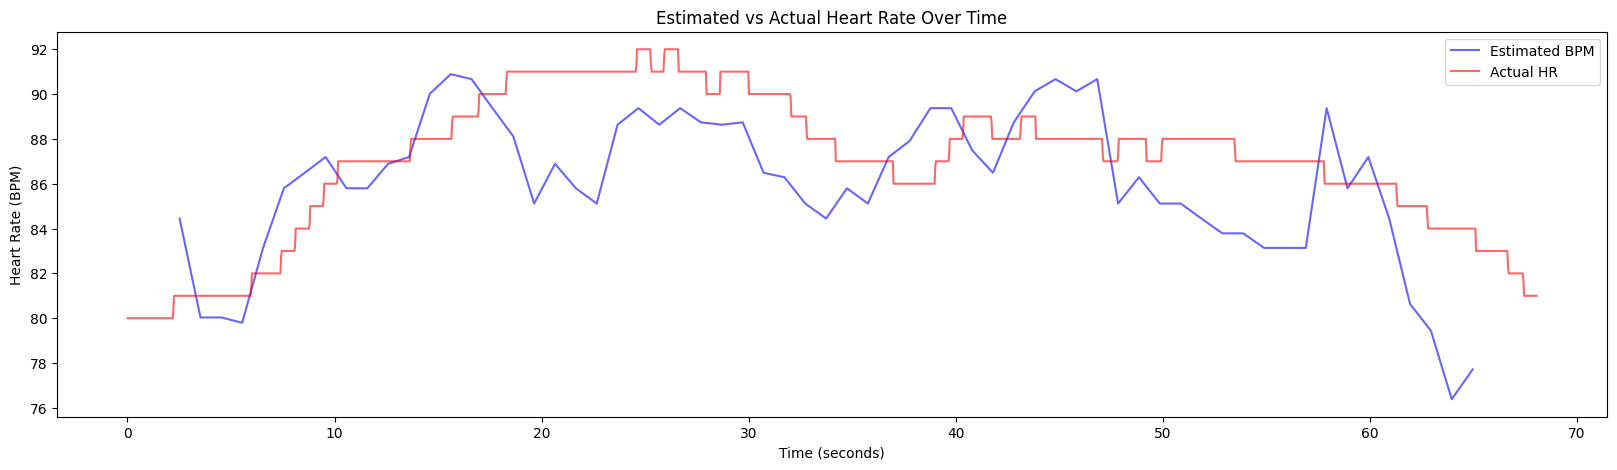

Average Estimated BPM: 86.06
Average Actual HR: 86.97
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject41.npz...


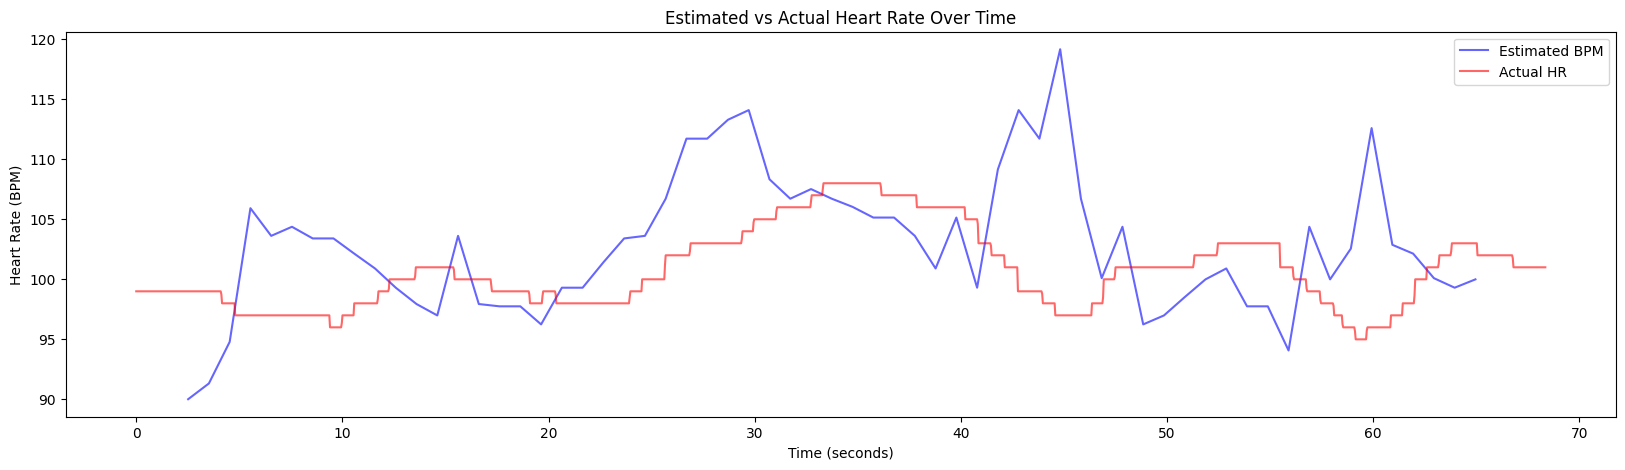

Average Estimated BPM: 102.83
Average Actual HR: 100.78
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject42.npz...


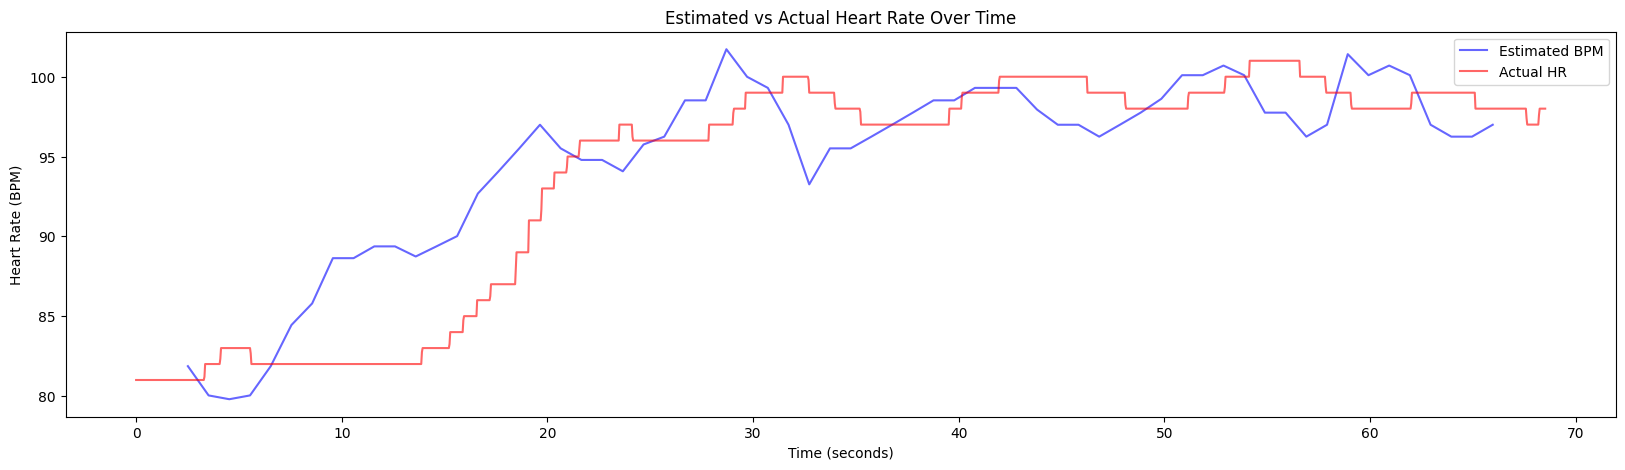

Average Estimated BPM: 94.90
Average Actual HR: 93.87
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject43.npz...


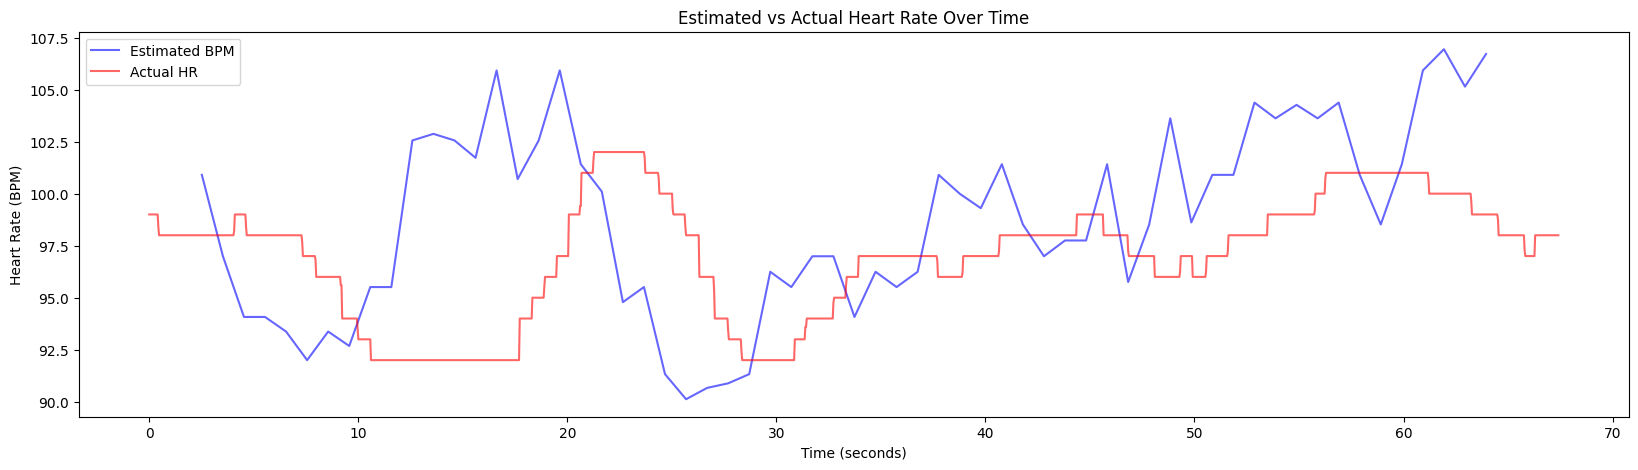

Average Estimated BPM: 98.80
Average Actual HR: 97.04
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject44.npz...


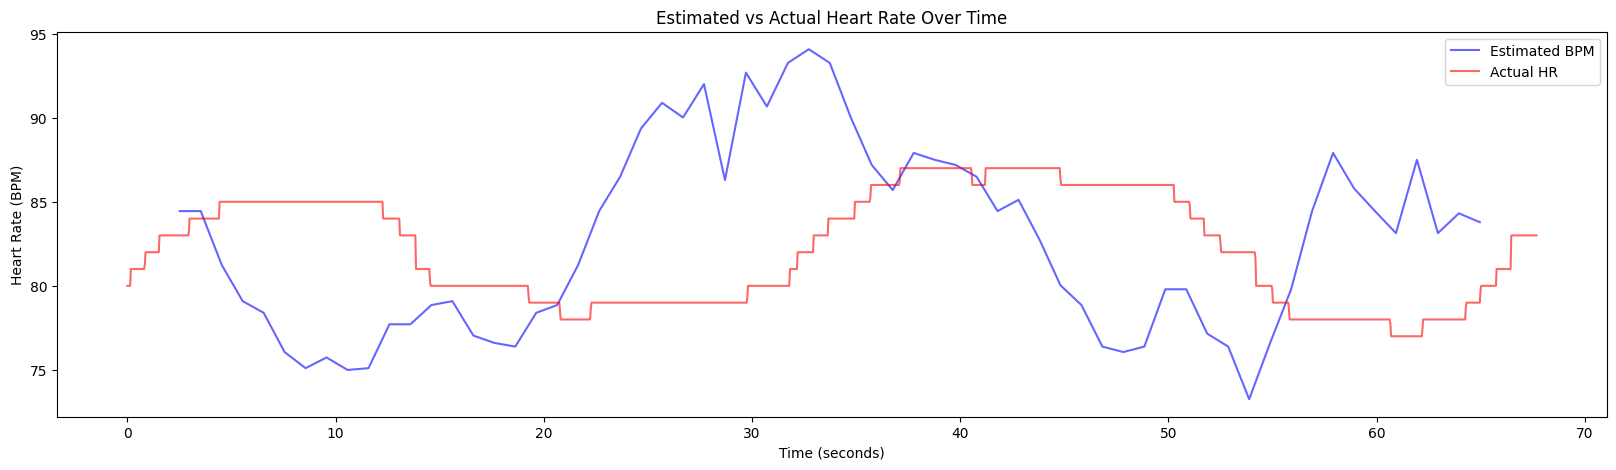

Average Estimated BPM: 82.69
Average Actual HR: 82.21
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject45.npz...


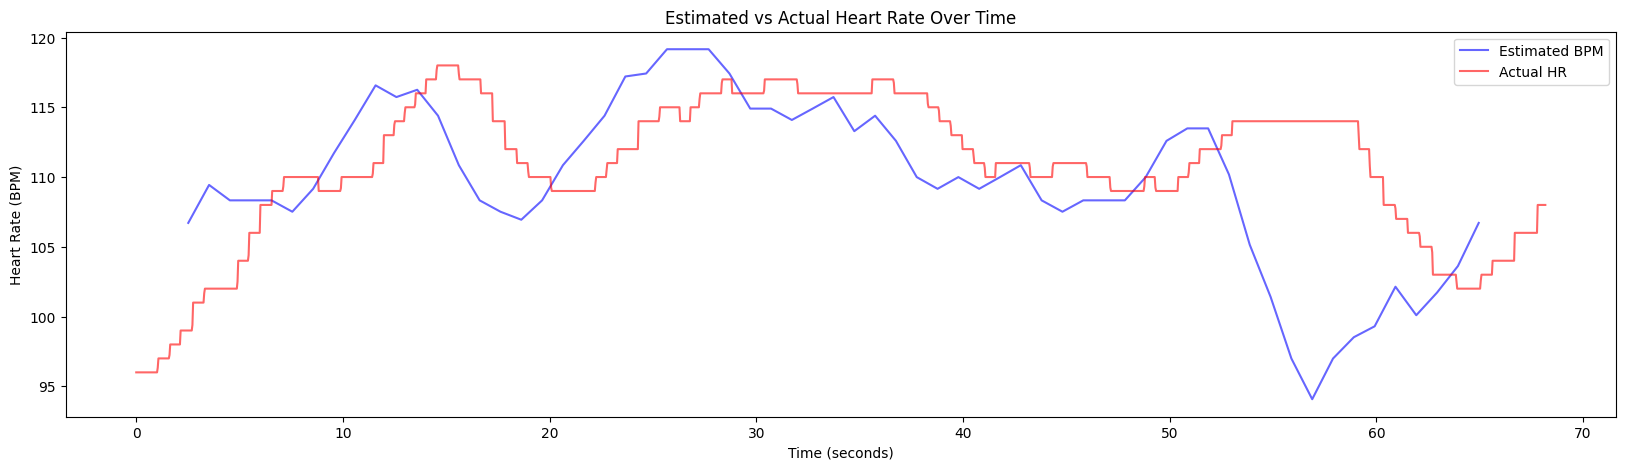

Average Estimated BPM: 109.80
Average Actual HR: 110.82
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject46.npz...


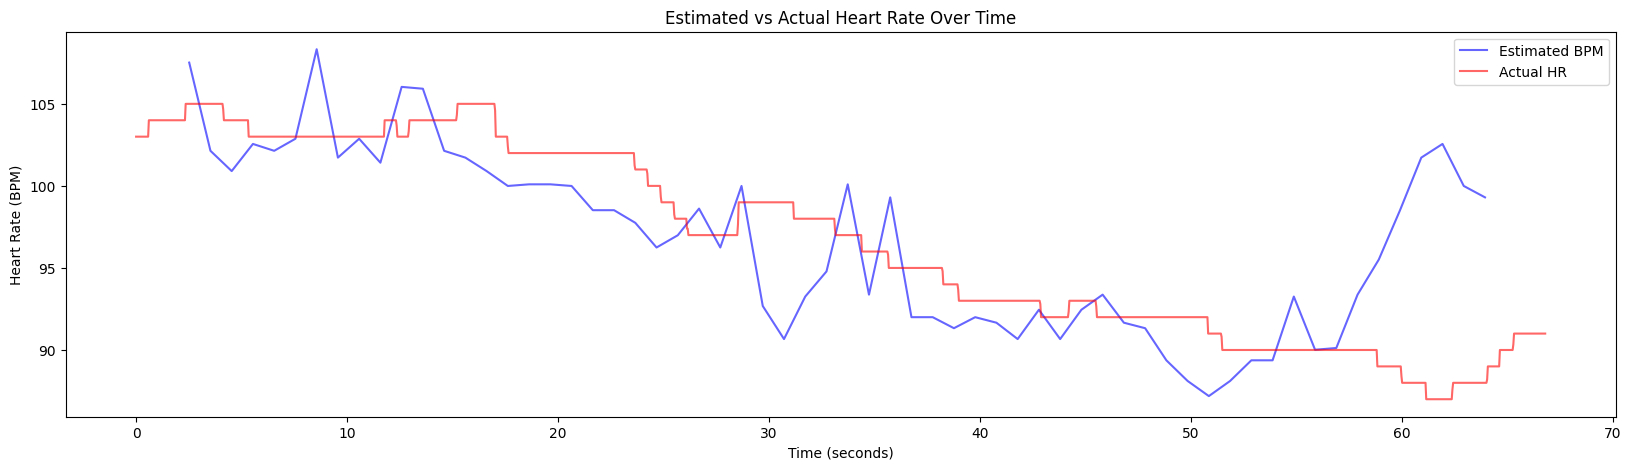

Average Estimated BPM: 96.68
Average Actual HR: 96.68
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject47.npz...


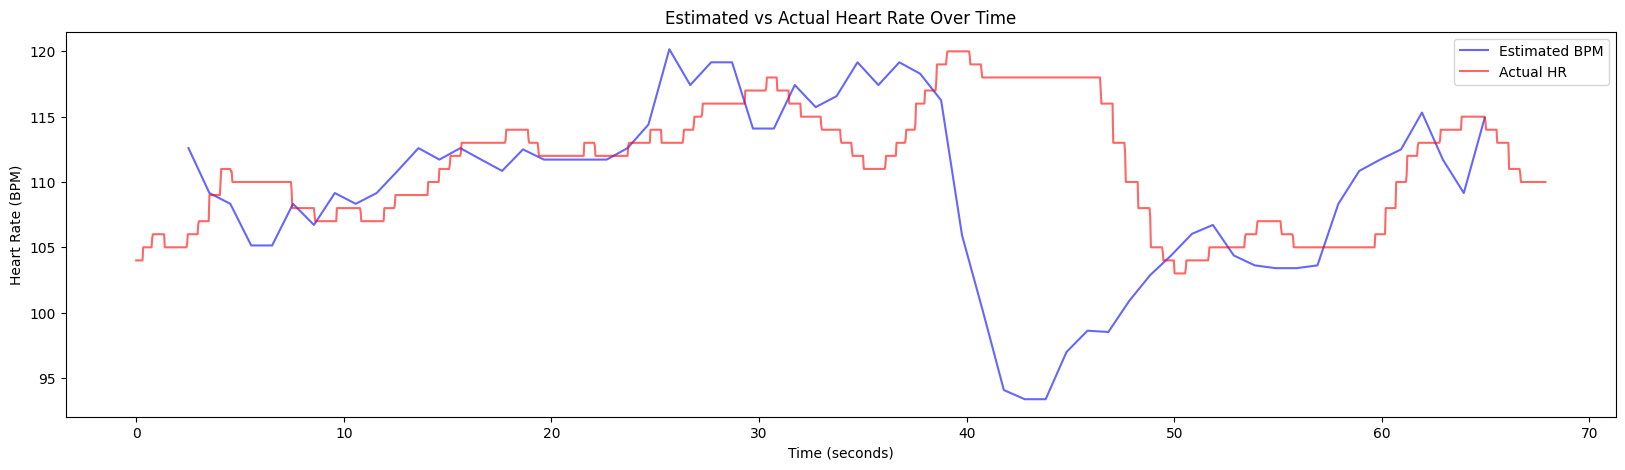

Average Estimated BPM: 109.48
Average Actual HR: 111.38
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject48.npz...


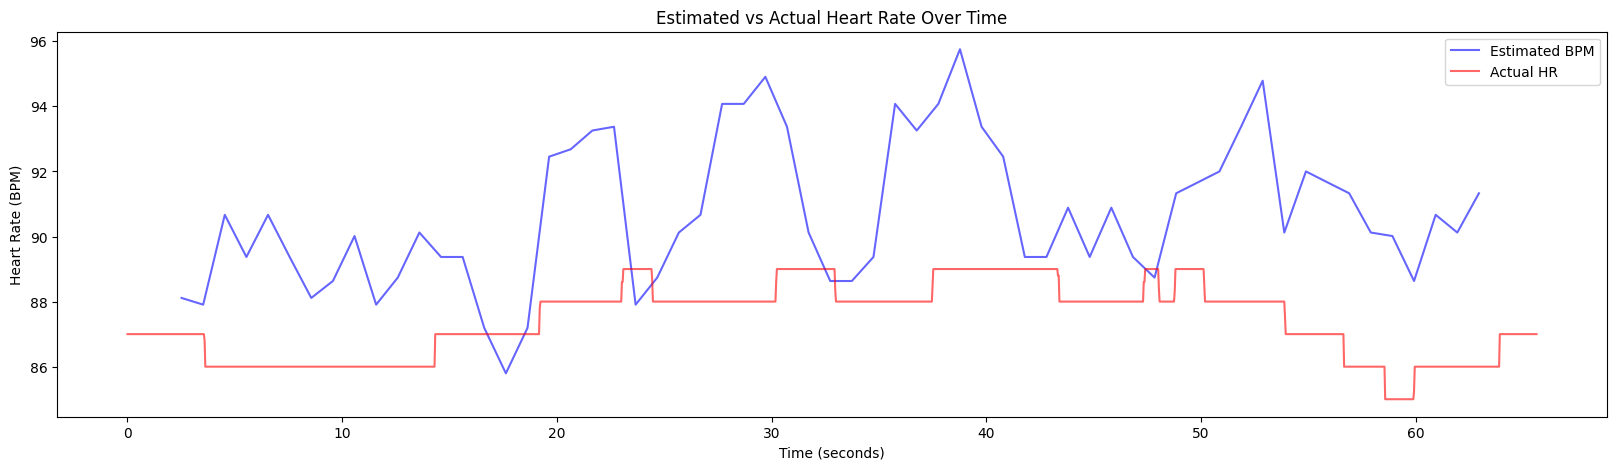

Average Estimated BPM: 90.67
Average Actual HR: 87.42
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject49.npz...


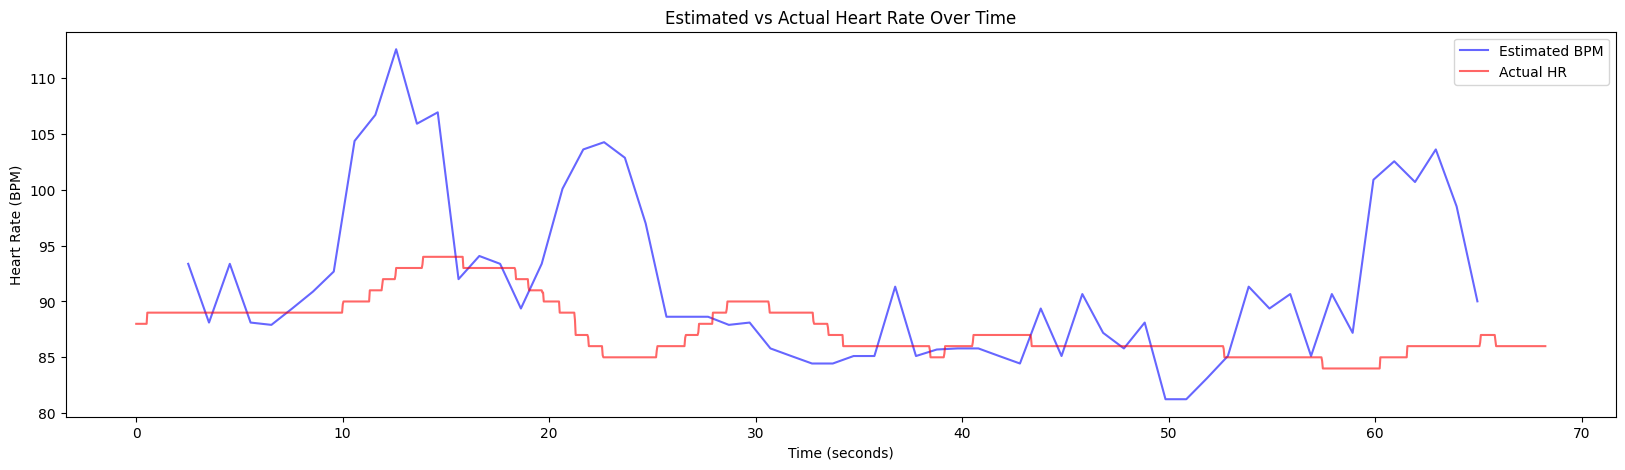

Average Estimated BPM: 91.64
Average Actual HR: 87.57
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject5.npz...


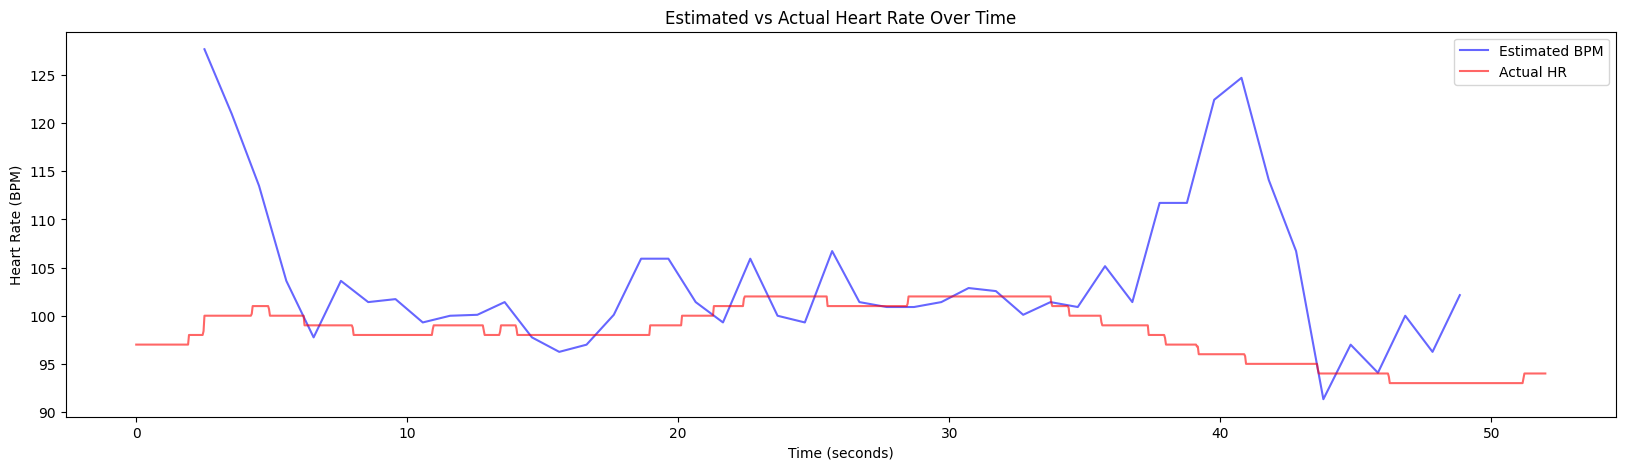

Average Estimated BPM: 103.78
Average Actual HR: 98.28
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject8.npz...


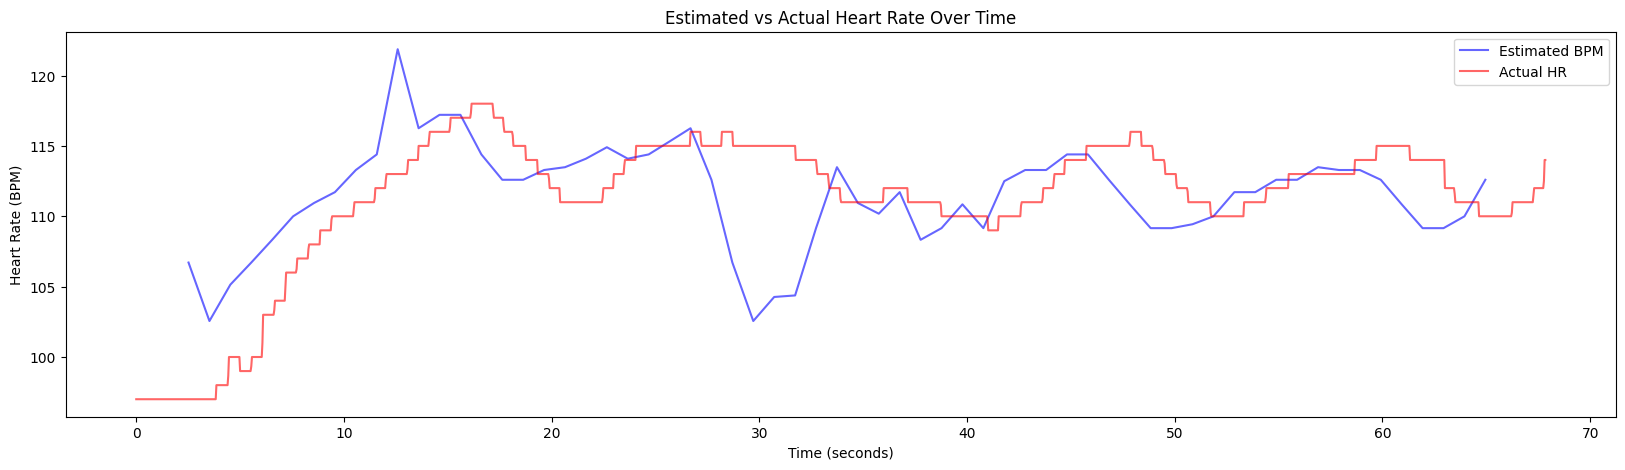

Average Estimated BPM: 111.48
Average Actual HR: 111.24
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject9.npz...


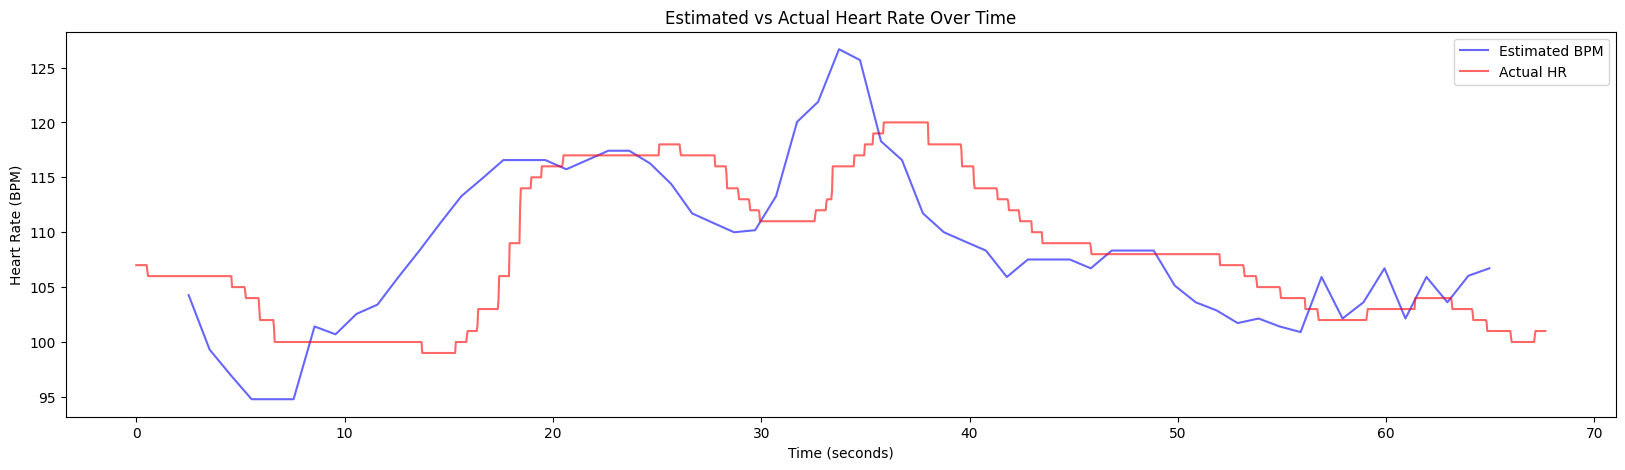

Average Estimated BPM: 108.55
Average Actual HR: 108.19
---------------------------------------------------------------------------


In [87]:
directory = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/'

process_npz_files(directory)